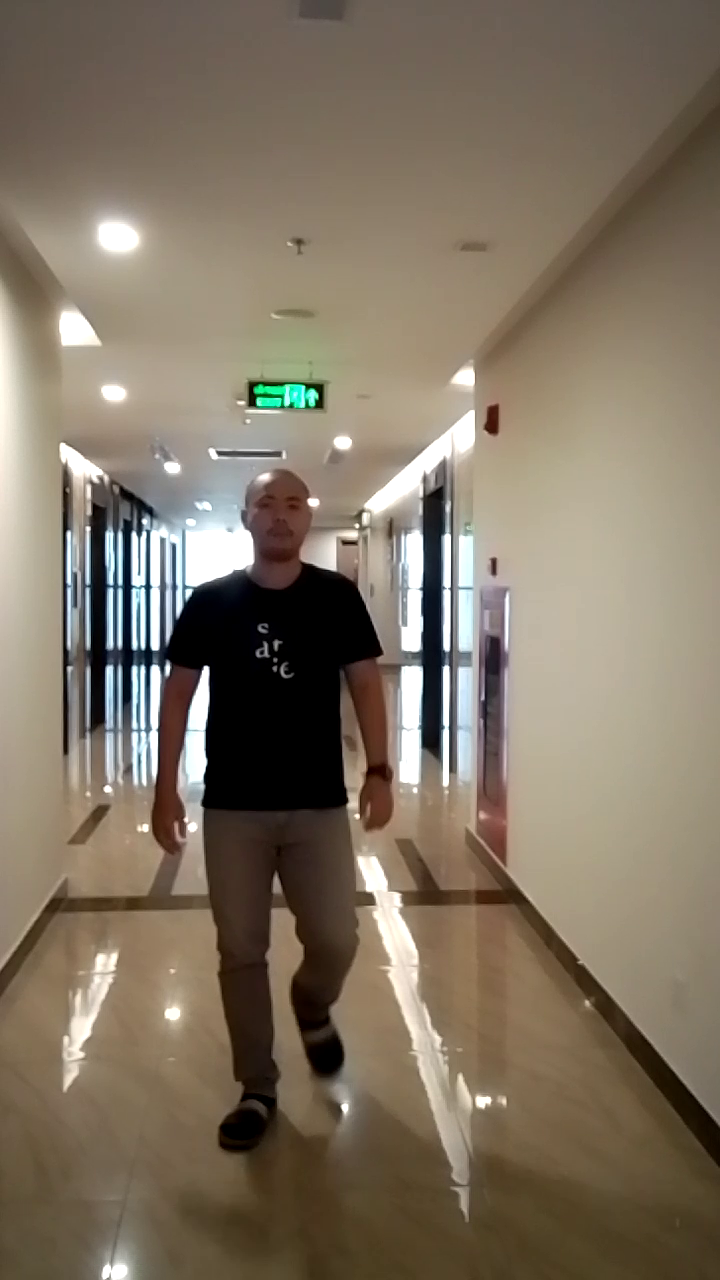

In [92]:
### Load Video and Display first Frame 
from torchvision.io import read_video
from torchvision.transforms.functional import to_pil_image
import os

video_path = os.path.join("Nov24","walking.mp4")
video, audio, meta = read_video(video_path, pts_unit="sec", output_format="TCHW")
fps = meta['video_fps']
frame_count = len(video)

sample_frame = to_pil_image(video[frame_count-20])
sample_frame = sample_frame.rotate(90, expand=True)
sample_frame

In [93]:
### Load Human Segmentation Model
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
model = maskrcnn_resnet50_fpn_v2(weights=weights)
transforms = weights.transforms()

model.eval().to("cpu")

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [101]:
### Transform Input Image for Inference
input_image = transforms(sample_frame)
input_image.dim()

3

In [105]:
### Run Segmentation Inference on sample frame
predictions = model([input_image.to("cpu")])
predictions

boxes = predictions[0]['boxes']
masks = predictions[0]['masks']
scores = predictions[0]['scores']
print(f"SCORES {scores} \n")

SCORES tensor([0.9999, 0.5835, 0.5227, 0.4740, 0.3299, 0.2047, 0.1566, 0.1002, 0.0794,
        0.0732, 0.0636, 0.0555, 0.0521], grad_fn=<IndexBackward0>) 



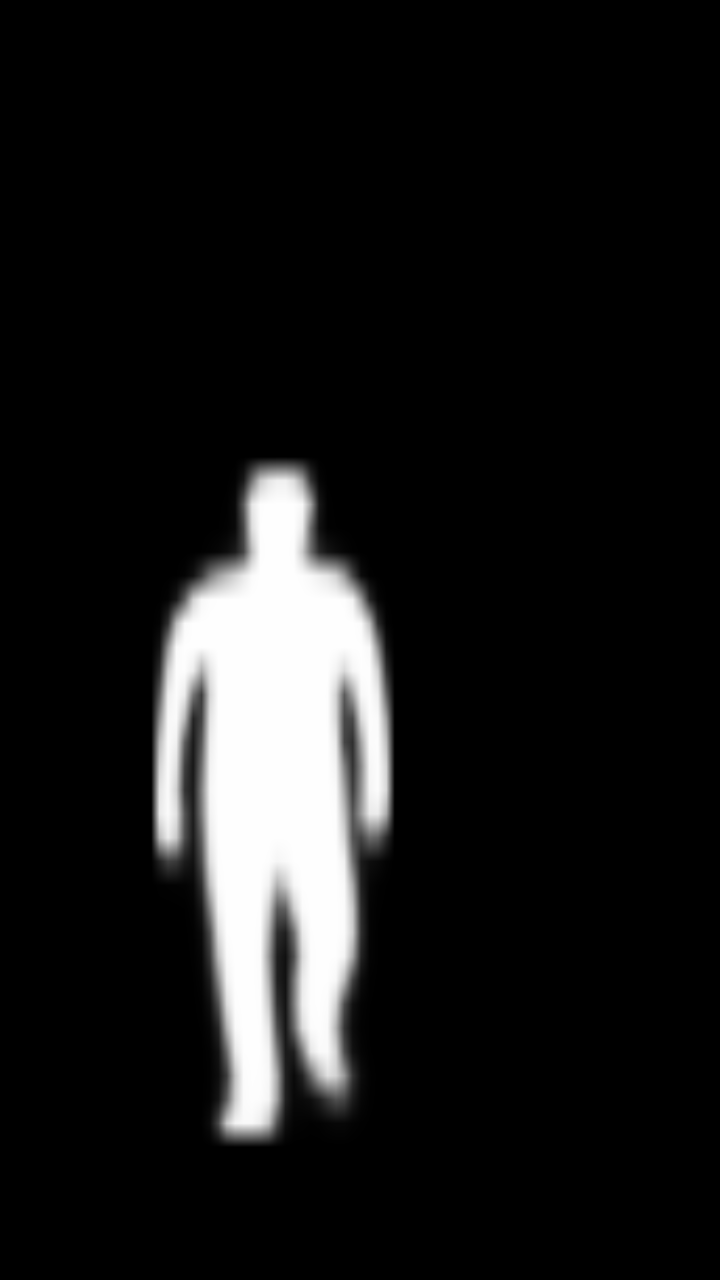

In [106]:
### Filtering for the Main Target
import torch

top = torch.max(scores)
idx = torch.where(scores == top)
bx = torch.unsqueeze(boxes[idx][0], dim=0)
mask =  torch.squeeze(masks[idx][0], dim=1)

mask_image = to_pil_image(mask)
mask_image

In [98]:
### Find the Minimum Pixel Threshold for Mask
histogram_data = torch.histogram(mask,255)
dist_data = histogram_data.hist
bin_data = histogram_data.bin_edges

min_value = torch.min(histogram_data.hist)
idx = torch.where(dist_data == min_value)
threshold = bin_data[idx]

int_mask = (mask > threshold)
print(threshold, int_mask)

tensor([0.4627], grad_fn=<IndexBackward0>) tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])


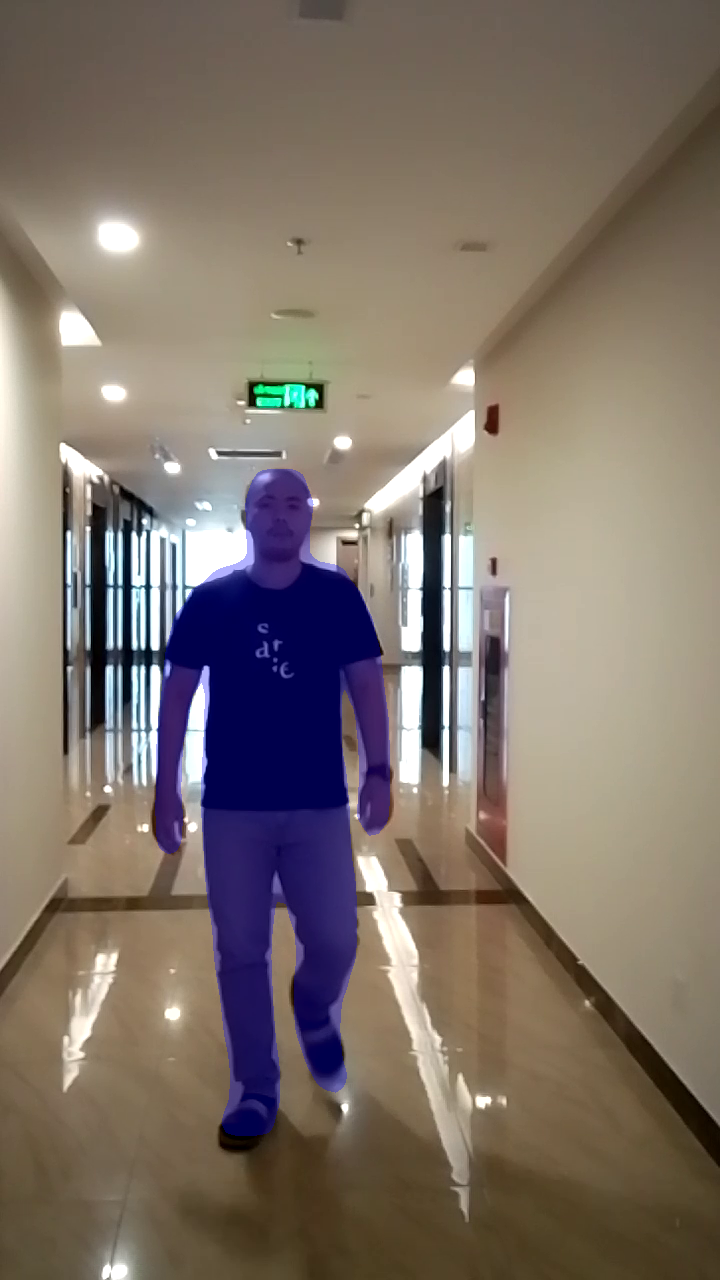

In [107]:
### Drawing Segmantion Mask 
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

tensor_image = pil_to_tensor(sample_frame)
masked_image = draw_segmentation_masks(tensor_image, int_mask, alpha=0.3, colors=["blue"])
final_image = to_pil_image(masked_image)
final_image